In [1]:
# Import packages
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Contest Portfolio Analysis

In [2]:
# Load processed data
entries_df = pd.read_csv('processed_contest_entries.csv')

In [ ]:
# Analyze contest economics
contest_economics = entries_df.groupby(['EntryFee']).agg({
    'EntryId': 'count',  # Total entries
    'EntryName': 'nunique',  # Unique users
}).reset_index()

# Rename columns
contest_economics.rename(columns={'EntryId': 'TotalEntries', 'EntryName': 'UniqueUsers'}, inplace=True)

In [4]:
# Calculate estimated revenue for each entry fee
contest_economics['EstimatedRevenue'] = contest_economics['TotalEntries'] * contest_economics['EntryFee']

In [28]:
# Calculate average revenue per user
contest_economics['AvgRevenuePerUser'] = round(contest_economics['EstimatedRevenue'] / contest_economics['UniqueUsers'], 2)

In [29]:
# Calculate percentage difference
contest_economics['% increase'] = round(((contest_economics['AvgRevenuePerUser'] - contest_economics['EntryFee']) / contest_economics['EntryFee']) * 100, 2)

In [5]:
# Calculate user overlap between entry fees
entry_fee_user_matrix = pd.crosstab(entries_df['EntryName'], entries_df['EntryFee'])
entry_fee_user_overlap = pd.DataFrame(index=entry_fee_user_matrix.columns, columns=entry_fee_user_matrix.columns)

for i in entry_fee_user_matrix.columns:
    for j in entry_fee_user_matrix.columns:
        users_in_i = set(entry_fee_user_matrix[entry_fee_user_matrix[i] > 0].index)
        users_in_j = set(entry_fee_user_matrix[entry_fee_user_matrix[j] > 0].index)
        
        overlap = len(users_in_i.intersection(users_in_j))
        total = len(users_in_i.union(users_in_j))
        
        entry_fee_user_overlap.loc[i, j] = overlap / total if total > 0 else 0

In [6]:
# Calculate user acquisition channels
users_first_contest = entries_df.sort_values('Date').drop_duplicates('EntryName')
acquisition_by_type = users_first_contest['EntryFee'].value_counts(normalize=True) * 100

In [ ]:
# Business Insight: Contest portfolio efficiency
contest_type_economics = contest_economics.groupby('EntryFee').agg({
    'EstimatedRevenue': 'sum',
    'TotalEntries': 'sum',
    'UniqueUsers': 'sum'
}).reset_index()

contest_type_economics['AvgRevenuePerEntry'] = round(contest_type_economics['EstimatedRevenue'] / contest_type_economics['TotalEntries'], 2)
contest_type_economics['AvgRevenuePerUser'] = round(contest_type_economics['EstimatedRevenue'] / contest_type_economics['UniqueUsers'], 2)
contest_type_economics['EntriesPerUser'] = round(contest_type_economics['TotalEntries'] / contest_type_economics['UniqueUsers'], 2)

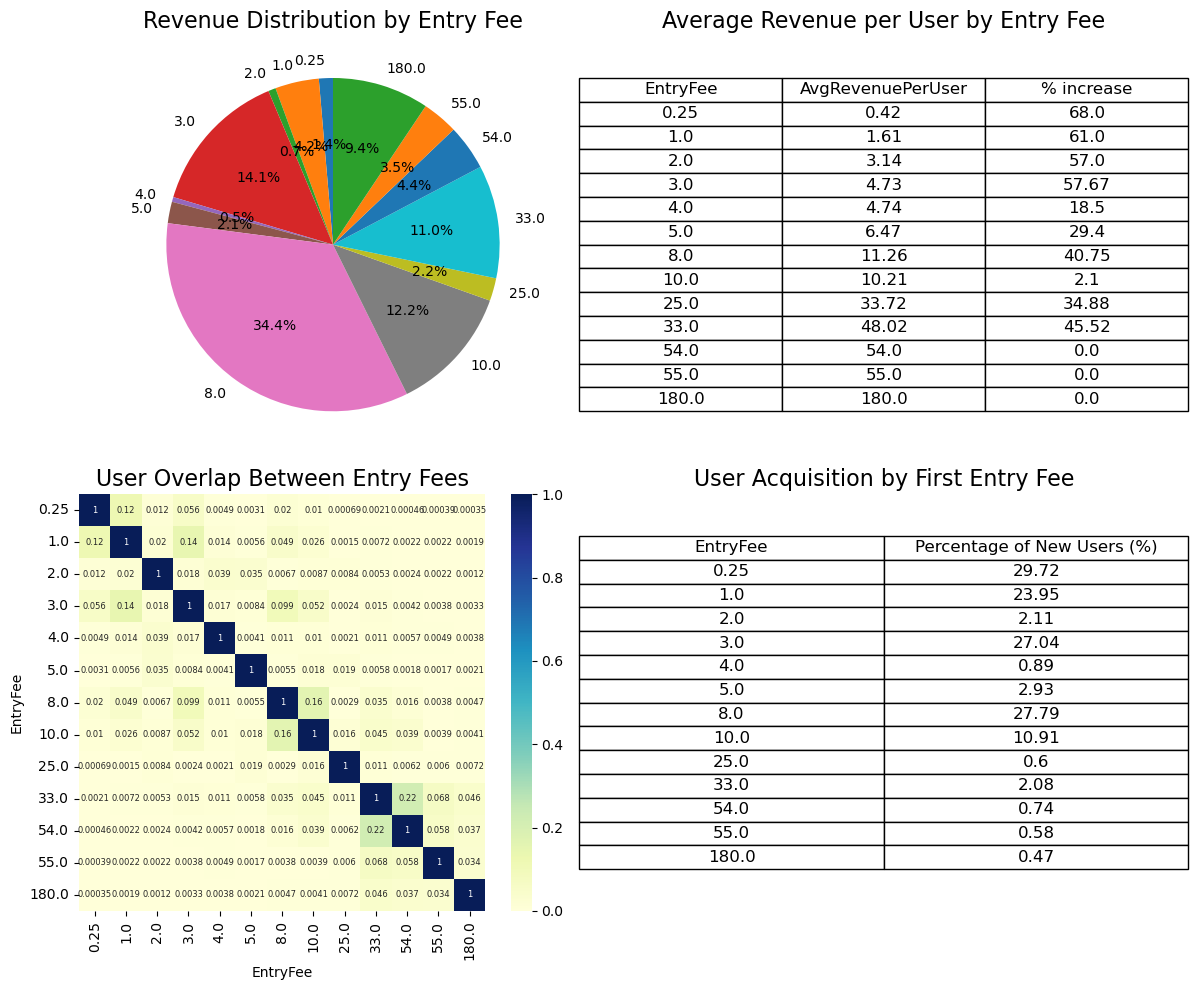

In [34]:
# Pie chart for revenue distribution by entry fee
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.pie(contest_type_economics['EstimatedRevenue'], 
        labels=contest_type_economics['EntryFee'],
        autopct='%1.1f%%',
        startangle=90)
plt.title('Revenue Distribution by Entry Fee', fontsize=16)

# Table for average revenue per user by entry fee
plt.subplot(2, 2, 2)
plt.axis('off')
table_data = contest_economics[['EntryFee', 'AvgRevenuePerUser', '% increase']]
table = plt.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.title('Average Revenue per User by Entry Fee', fontsize=16)

# Heatmap for user overlap between entry fees
plt.subplot(2, 2, 3)
sns.heatmap(entry_fee_user_overlap.astype(float), annot=True, cmap='YlGnBu', vmin=0, vmax=1, annot_kws={'fontsize': 6})
plt.title('User Overlap Between Entry Fees', fontsize=16)

# Table for user acquisition by first entry fee
plt.subplot(2, 2, 4)
plt.axis('off')
acquisition_by_type = round(entries_df.groupby('EntryFee')['EntryName'].nunique() / entries_df['EntryName'].nunique() * 100, 2)
acquisition_table_data = acquisition_by_type.reset_index()
acquisition_table_data.columns = ['EntryFee', 'Percentage of New Users (%)']
table = plt.table(cellText=acquisition_table_data.values, colLabels=acquisition_table_data.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.title('User Acquisition by First Entry Fee', fontsize=16)

plt.tight_layout()
plt.savefig('contest_portfolio_analysis.png', dpi=300)